# Hadamard Multitask GP Regression

## Introduction

This notebook demonstrates how to perform "Hadamard" multitask regression. 
This differs from the [multitask gp regression example notebook](./Multitask_GP_Regression.ipynb) in one key way:

- Here, we assume that we have observations for **one task per input**. For each input, we specify the task of the input that we observe. (The kernel that we learn is expressed as a Hadamard product of an input kernel and a task kernel)
- In the other notebook, we assume that we observe all tasks per input. (The kernel in that notebook is the Kronecker product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial).

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a special kernel - the `IndexKernel` - which is a lookup table containing inter-task covariance.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. For each task we'll be using 50 random points on [0,1), which we evaluate the function on and add Gaussian noise to get the training labels. Note that different inputs are used for each task.

We'll have two functions - a sine function (y1) and a cosine function (y2).

In [2]:
TASK_NOISES = [math.sqrt(0.3), math.sqrt(0.1)]
torch.manual_seed(1)
train_x1 = torch.rand(20)
train_x2 = torch.rand(20)

train_i_task1 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x2.shape[0],1), dtype=torch.long, fill_value=1)

train_f1 = torch.sin(train_x1 * (2 * math.pi))
train_f2 = torch.cos(train_x2 * (2 * math.pi))

train_noise1 = torch.randn(train_f1.size())
train_noise2 = torch.randn(train_f2.size())

full_train_x = torch.cat([train_x1, train_x2])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_f = torch.cat([train_f1, train_f2])
full_train_noise = torch.cat([TASK_NOISES[0] * train_noise1, TASK_NOISES[1] * train_noise2])
full_train_y = full_train_f + full_train_noise


## Set up a Hadamard multitask model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).

The differences:

1. The model takes two input: the inputs (x) and indices. The indices indicate which task the observation is for.
2. Rather than just using a RBFKernel, we're using that in conjunction with a IndexKernel.
3. We don't use a ScaleKernel, since the IndexKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)
        
        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

### Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

See the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb) for more info on this step.

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 100

# We define the training loop in a function, which will let us use
# it again later for a different likelihood.
def train_model(train_data, likelihood_cls: type[gpytorch.likelihoods.Likelihood]):
    likelihood = likelihood_cls(num_tasks=2)
    (train_x, train_i), train_y = train_data
    # Here we have two terms that we're passing in as train_inputs
    model = MultitaskGPModel((train_x, train_i), train_y, likelihood)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x, train_i)
        loss = -mll(output, train_y, [train_i])
        loss.backward()
        if (i + 1) % 25 == 0:
            print(f'Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}')
        optimizer.step()

    
    # Set into eval mode
    model.eval()
    likelihood.eval()

    return model, likelihood

model, likelihood = train_model(
    ((full_train_x, full_train_i), full_train_y), 
    gpytorch.likelihoods.GaussianLikelihood
)

c:\Users\tobyb\phd\gpytorch\venv\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:646.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 25/100 - Loss: 1.012
Iter 50/100 - Loss: 1.004
Iter 75/100 - Loss: 1.003
Iter 100/100 - Loss: 1.003


### Make predictions with the model

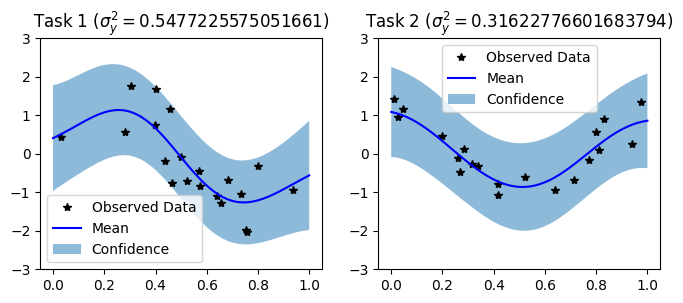

In [5]:
# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1, 51)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x, test_i_task1), [test_i_task1])
    observed_pred_y2 = likelihood(model(test_x, test_i_task2), [test_i_task2])


# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
train_y1 = train_f1 + TASK_NOISES[0] * train_noise1
train_y2 = train_f2 + TASK_NOISES[1] * train_noise2
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, fr'Task 1 ($\sigma_y^2 = {TASK_NOISES[0]}$)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, fr'Task 2 ($\sigma_y^2 = {TASK_NOISES[1]}$)')

## Task-specific Noise

In this notebook so far, we assumed that each task had the same noise. However, 
this may be too strong an assumption. In this section, we use the `HadamardGaussianLikelihood`
to learn independent noises for each task.

In [6]:
model_hd, likelihood_hd = train_model(
    ((full_train_x, full_train_i), full_train_y), 
    gpytorch.likelihoods.HadamardGaussianLikelihood
)

Iter 25/100 - Loss: 0.942
Iter 50/100 - Loss: 0.935
Iter 75/100 - Loss: 0.933
Iter 100/100 - Loss: 0.933


First, we compare the models when the tasks have significantly different noises. 
Note that the training loss achieved using the `HadamardGaussianLikelihood` is lower
than using `GaussianLikelihood`, which learns the same noise across all tasks. 
We also see that the predictive distribution for task 2 is much tighter.

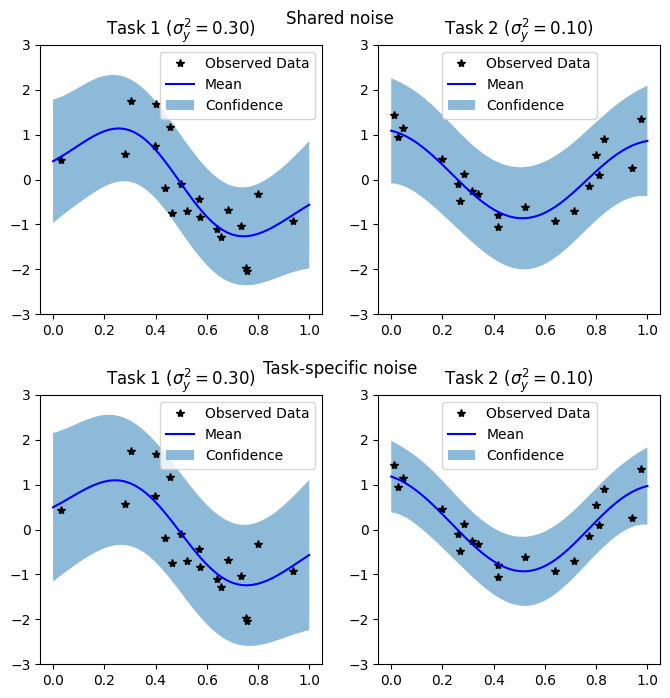

In [7]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1_hd = likelihood_hd(model_hd(test_x, test_i_task1), [test_i_task1])
    observed_pred_y2_hd = likelihood_hd(model_hd(test_x, test_i_task2), [test_i_task2])

train_y1 = train_f1 + TASK_NOISES[0] * train_noise1
train_y2 = train_f2 + TASK_NOISES[1] * train_noise2

fig = plt.figure(figsize=(8, 7))
subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle('Shared noise')
subfigs[1].suptitle('Task-specific noise')

for row, (subfig, pred_y1, pred_y2) in enumerate(zip(subfigs, (observed_pred_y1, observed_pred_y1_hd), (observed_pred_y2, observed_pred_y2_hd))):
    y1_ax, y2_ax = subfig.subplots(1, 2)
    ax_plot(y1_ax, train_y1, train_x1, pred_y1, fr'Task 1 ($\sigma_y^2 = {TASK_NOISES[0]**2:.2f}$)')
    ax_plot(y2_ax, train_y2, train_x2, pred_y2, fr'Task 2 ($\sigma_y^2 = {TASK_NOISES[1]**2:.2f}$)')


### Failure case of task-specific noise

The downside to this approach is that, since each task has its own noise, learning
the noise parameter requires more data. We demonstrate this failure case below,
where each task has the same noise. In the low-data regime, learning a single
noise parameter gives accurate results, however the task-specific noises are not accurate,
with task 1 overestimating the noise, and task 2 underestimating.

This can be mitigated by setting the `noise_prior` argument of the likelihood.

Iter 25/100 - Loss: 1.190
Iter 50/100 - Loss: 1.189
Iter 75/100 - Loss: 1.188
Iter 100/100 - Loss: 1.188
likelihood.noise=tensor([0.3621], grad_fn=<AddBackward0>)
Iter 25/100 - Loss: 1.150
Iter 50/100 - Loss: 1.137
Iter 75/100 - Loss: 1.136
Iter 100/100 - Loss: 1.136
likelihood.noise=tensor([0.5248, 0.1473], grad_fn=<AddBackward0>)


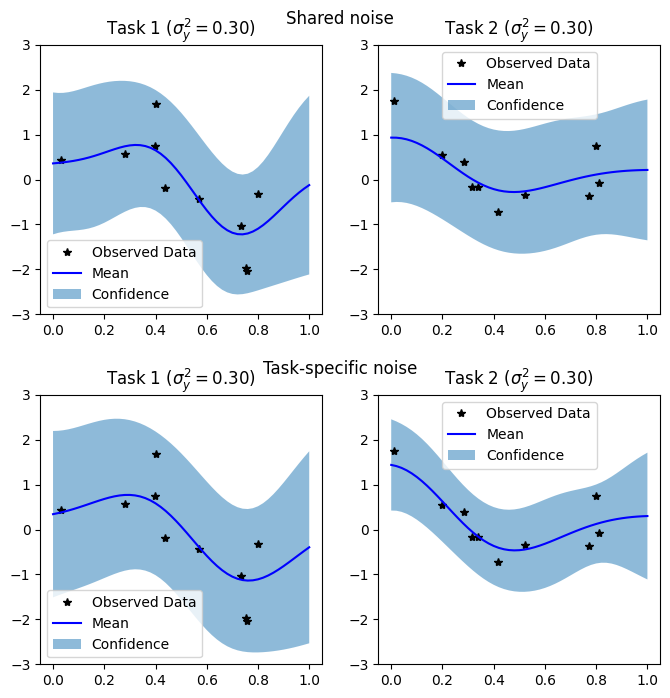

In [8]:
fig = plt.figure(figsize=(8, 7))
subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle('Shared noise')
subfigs[1].suptitle('Task-specific noise')

# Reduce the size of the training set to show the effect of independent noises
# in low data settings
N_train = 10
TASK_NOISE = TASK_NOISES[0]
full_train_x = torch.cat([train_x1[:N_train], train_x2[:N_train]])
full_train_i = torch.cat([train_i_task1[:N_train], train_i_task2[:N_train]])
full_train_f = torch.cat([train_f1[:N_train], train_f2[:N_train]])
full_train_noise = torch.cat([TASK_NOISE * train_noise1[:N_train], TASK_NOISE * train_noise2[:N_train]])
full_train_y = full_train_f + full_train_noise

likelihoods = (gpytorch.likelihoods.GaussianLikelihood, gpytorch.likelihoods.HadamardGaussianLikelihood)
for row, (subfig, likelihood_cls) in enumerate(zip(subfigs, likelihoods)):
    model, likelihood = train_model(
        ((full_train_x, full_train_i), full_train_y), 
        likelihood_cls
    )

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred_y1 = likelihood(model(test_x, test_i_task1), [test_i_task1])
        observed_pred_y2 = likelihood(model(test_x, test_i_task2), [test_i_task2])

    y1_ax, y2_ax = subfig.subplots(1, 2)
    train_x1_sub = train_x1[:N_train]
    train_x2_sub = train_x2[:N_train]
    train_y1_sub = train_f1[:N_train] + TASK_NOISE * train_noise1[:N_train]
    train_y2_sub = train_f2[:N_train] + TASK_NOISE * train_noise2[:N_train]
    ax_plot(y1_ax, train_y1_sub, train_x1_sub, observed_pred_y1, fr'Task 1 ($\sigma_y^2 = {TASK_NOISE**2:.2f}$)')
    ax_plot(y2_ax, train_y2_sub, train_x2_sub, observed_pred_y2, fr'Task 2 ($\sigma_y^2 = {TASK_NOISE**2:.2f}$)')

    # Print the standard deviation, sigma_y which should be 
    # close to TASK_NOISE
    print(f"{likelihood.noise=}")